In [1]:
from Utilities.models_2_0 import *
import matplotlib.pyplot as plt

In [2]:
excel_filename = 'Eurofer/Eurofer_data_1_2.xlsx'
material_property = "Ultimate Strength_SH"
var_names, variables, dataframe = load_data(excel_filename, material_property, header_rows_list=[1, 3], num_data_rows=20, display_data_table_bool=False)

X0 = np.concatenate(variables[::2])
y0 = np.concatenate(variables[1::2])

print(X0.shape)
print(y0.shape)

(166,)
(166,)


In [3]:
material_property1 = "Yield Strength_SH"
var_names, variables, dataframe = load_data(excel_filename, material_property1, header_rows_list=[1, 3], num_data_rows=20, display_data_table_bool=False)

X1 = np.concatenate(variables[::2])
y1 = np.concatenate(variables[1::2])
print(X1.shape)
print(y1.shape)

(191,)
(191,)


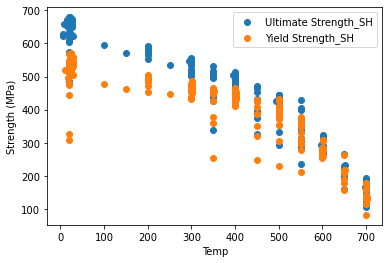

In [4]:
plt.scatter(X0, y0, label = material_property)
plt.scatter(X1, y1, label = material_property1)
plt.ylabel("Strength (MPa)")
plt.xlabel("Temp")
plt.legend()
plt.show()

### General NN

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset

In [7]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X0.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(y0.reshape(-1, 1))

X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

In [9]:
dataset = TensorDataset(X,y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [10]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
learning_rate = 4e-3
weight_decay = 1e-5
model = Model(input_size = 1, hidden_size = 16, output_size = 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [12]:
epochs = 30
Losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    if (epoch + 1) % 3 == 0:
        Losses.append(total_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')

Epoch [3/30], Loss: 0.1752
Epoch [6/30], Loss: 0.0832
Epoch [9/30], Loss: 0.0681
Epoch [12/30], Loss: 0.0428
Epoch [15/30], Loss: 0.0204
Epoch [18/30], Loss: 0.0101
Epoch [21/30], Loss: 0.0055
Epoch [24/30], Loss: 0.0049
Epoch [27/30], Loss: 0.0049
Epoch [30/30], Loss: 0.0040


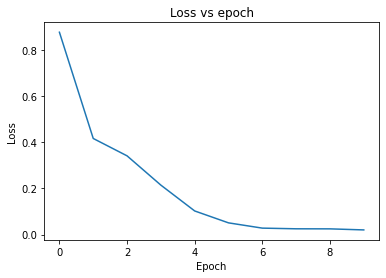

In [13]:
plt.plot(Losses)
plt.title("Loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [14]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(test_loader):.4f}')

Test Loss: 0.0030


In [15]:
X_test = np.arange(1,701).reshape(-1, 1)
X_test = scaler_X.transform(X_test)
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(X_test, dtype=torch.float32))
    predictions = scaler_y.inverse_transform(predictions.detach().numpy())

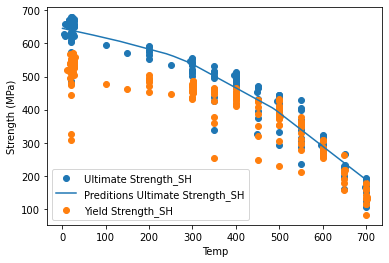

In [16]:
plt.scatter(X0, y0, label = material_property)
plt.plot(scaler_X.inverse_transform(X_test), predictions, label = f"Preditions {material_property}" )
plt.scatter(X1, y1, label = material_property1)

plt.ylabel("Strength (MPa)")
plt.xlabel("Temp")
plt.legend()
plt.show()

### K-Fold Cross Validation

In [18]:
from sklearn.model_selection import KFold


dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [19]:
def kfold_trian(dataset, kf, model, criterion, optimizer, epochs = 30):
    TrainLoss = []
    ValLoss = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
    
        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
            # Prepare data for this fold
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)
    
            train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
            # Training phase
            fold_train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                loss.backward()
                optimizer.step()
                fold_train_loss += loss.item()
            total_train_loss += fold_train_loss / len(train_loader)
    
            # Validation phase
            model.eval()
            fold_val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    predictions = model(batch_X)
                    loss = criterion(predictions, batch_y)
                    fold_val_loss += loss.item()
            total_val_loss += fold_val_loss / len(val_loader)
    
        if (epoch + 1) % 1 == 0:
            avg_train_loss = total_train_loss / num_folds
            avg_val_loss = total_val_loss / num_folds
            print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            
        if (epoch + 1) % 1 == 0:
            TrainLoss.append(total_train_loss / num_folds)
            ValLoss.append(total_val_loss / num_folds)
            
    return model, TrainLoss, ValLoss

In [20]:
model = Model(input_size=1, hidden_size=16, output_size=1)
criterion = nn.MSELoss()
learning_rate = 4e-3
weight_decay = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

model, TrainLoss, ValLoss = kfold_trian(train_dataset, kf, model, criterion, optimizer)

Epoch [1/30] - Train Loss: 0.1639, Val Loss: 0.1593
Epoch [2/30] - Train Loss: 0.0623, Val Loss: 0.0490
Epoch [3/30] - Train Loss: 0.0209, Val Loss: 0.0179
Epoch [4/30] - Train Loss: 0.0091, Val Loss: 0.0082
Epoch [5/30] - Train Loss: 0.0084, Val Loss: 0.0074
Epoch [6/30] - Train Loss: 0.0061, Val Loss: 0.0061
Epoch [7/30] - Train Loss: 0.0060, Val Loss: 0.0055
Epoch [8/30] - Train Loss: 0.0051, Val Loss: 0.0057
Epoch [9/30] - Train Loss: 0.0051, Val Loss: 0.0051
Epoch [10/30] - Train Loss: 0.0047, Val Loss: 0.0048
Epoch [11/30] - Train Loss: 0.0046, Val Loss: 0.0045
Epoch [12/30] - Train Loss: 0.0042, Val Loss: 0.0043
Epoch [13/30] - Train Loss: 0.0050, Val Loss: 0.0046
Epoch [14/30] - Train Loss: 0.0045, Val Loss: 0.0046
Epoch [15/30] - Train Loss: 0.0045, Val Loss: 0.0042
Epoch [16/30] - Train Loss: 0.0045, Val Loss: 0.0042
Epoch [17/30] - Train Loss: 0.0045, Val Loss: 0.0040
Epoch [18/30] - Train Loss: 0.0048, Val Loss: 0.0041
Epoch [19/30] - Train Loss: 0.0038, Val Loss: 0.0041
Ep

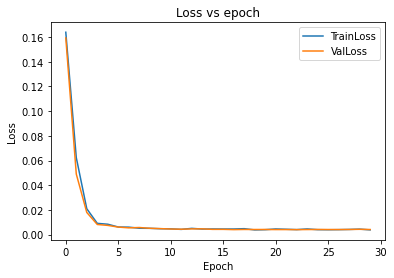

In [21]:
plt.plot(TrainLoss, label = "TrainLoss")
plt.plot(ValLoss, label = "ValLoss")
plt.title("Loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_dataset:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(test_dataset):.4f}')

Test Loss: 0.0046


In [23]:
model.eval()
train_loss = 0
with torch.no_grad():
    for batch_X, batch_y in train_dataset:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        train_loss += loss.item()

print(f'Train Loss: {train_loss / len(train_dataset):.4f}')

Train Loss: 0.0040


In [24]:
X_test = np.arange(1,701).reshape(-1, 1)
X_test = scaler_X.transform(X_test)
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(X_test, dtype=torch.float32))
    predictions = scaler_y.inverse_transform(predictions.detach().numpy())

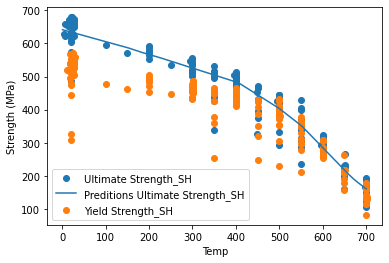

In [25]:
plt.scatter(X0, y0, label = material_property)
plt.plot(scaler_X.inverse_transform(X_test), predictions, label = f"Preditions {material_property}" )
plt.scatter(X1, y1, label = material_property1)

plt.ylabel("Strength (MPa)")
plt.xlabel("Temp")
plt.legend()
plt.show()

# Neural Network Improvement Strategies

## 1. **Data Augmentation**
- Helps prevent overfitting and improves model generalization.

## 2. **Feature Engineering / More Descriptors**
- Extract meaningful features from raw data to improve the model’s ability to learn.
- Example: Add domain-specific descriptors or combine existing features in new ways.

## 3. **Data Normalization**
- Improves convergence speed and prevents numerical instability.

## 4. **Hyperparameter Tuning**
- Optimize key parameters such as:
  - Learning rate
  - Number of hidden layers and neurons
  - Batch size
- Grid Search, Random Search, or Bayesian Optimization

## 5. **Evaluation Metrics**
  - RMSE
  - Accuracy
  - Precision/Recall
  - F1 Score
  - Mean Absolute Error (MAE)

## 6. **Experiment with Optimizers**
  - Adam
  - SGD with momentum
  - RMSProp
  - AdamW

## 7. **Regularization**
- Reduce overfitting using:
  - Dropout
  - L2 regularization
  - Early stopping based on validation loss

## 8. **More Complex Neural Network Architectures**
- Experiment with advanced architectures such as:
  - Adding more layers and neurons (Deep Neural Networks)
  - Attention mechanisms for focusing on relevant parts of data
  - Transformers

## 9. **Ensemble Learning**
- Combine predictions from multiple models to improve robustness:
  - Averaging
  - Bagging or boosting techniques



In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
def scale(material_property):
    var_names, variables, dataframe = load_data(excel_filename, material_property, header_rows_list=[1, 3], num_data_rows=20, display_data_table_bool=False)
    
    X = np.concatenate(variables[::2])
    y = np.concatenate(variables[1::2])
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X.reshape(-1, 1))
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    X = torch.tensor(X_scaled, dtype=torch.float32)
    y = torch.tensor(y_scaled, dtype=torch.float32)
    return X,y,scaler_X,scaler_y

In [29]:
UltimateStrength_X, UltimateStrength_y, UltimateStrength_scaler_X, UltimateStrength_scaler_y = scale(material_property="Ultimate Strength_SH")
YieldStrength_X, YieldStrength_y, YieldStrength_scaler_X, YieldStrength_scaler_y = scale(material_property="Yield Strength_SH")
TotalElongation_X, TotalElongation_y, TotalElongation_scaler_X, TotalElongation_scaler_y = scale(material_property="Total Elongation_SH")
UniformElongation_X, UniformElongation_y, UniformElongation_scaler_X, UniformElongation_scaler_y = scale(material_property="Uniform Elongation_SH")

**UltimateStrength**

In [31]:
dataset = TensorDataset(UltimateStrength_X, UltimateStrength_y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [32]:
kf = KFold(n_splits=num_folds, shuffle=True)
UltimateStrength_model = Model(input_size=1, hidden_size=16, output_size=1)
UltimateStrength_model, TrainLoss, ValLoss = kfold_trian(
    dataset = train_dataset, 
    kf = kf, 
    model = UltimateStrength_model, 
    criterion = nn.MSELoss(),
    optimizer = optim.Adam(UltimateStrength_model.parameters(), lr=4e-3, weight_decay=1e-5)
)

Epoch [1/30] - Train Loss: 0.1980, Val Loss: 0.1614
Epoch [2/30] - Train Loss: 0.0739, Val Loss: 0.0688
Epoch [3/30] - Train Loss: 0.0349, Val Loss: 0.0334
Epoch [4/30] - Train Loss: 0.0104, Val Loss: 0.0105
Epoch [5/30] - Train Loss: 0.0067, Val Loss: 0.0072
Epoch [6/30] - Train Loss: 0.0061, Val Loss: 0.0059
Epoch [7/30] - Train Loss: 0.0059, Val Loss: 0.0049
Epoch [8/30] - Train Loss: 0.0051, Val Loss: 0.0048
Epoch [9/30] - Train Loss: 0.0046, Val Loss: 0.0040
Epoch [10/30] - Train Loss: 0.0039, Val Loss: 0.0042
Epoch [11/30] - Train Loss: 0.0035, Val Loss: 0.0037
Epoch [12/30] - Train Loss: 0.0039, Val Loss: 0.0037
Epoch [13/30] - Train Loss: 0.0032, Val Loss: 0.0038
Epoch [14/30] - Train Loss: 0.0037, Val Loss: 0.0041
Epoch [15/30] - Train Loss: 0.0033, Val Loss: 0.0036
Epoch [16/30] - Train Loss: 0.0036, Val Loss: 0.0038
Epoch [17/30] - Train Loss: 0.0034, Val Loss: 0.0038
Epoch [18/30] - Train Loss: 0.0037, Val Loss: 0.0035
Epoch [19/30] - Train Loss: 0.0046, Val Loss: 0.0036
Ep

In [33]:
X_test = np.arange(1,701).reshape(-1, 1)
X_test = scaler_X.transform(X_test)
UltimateStrength_model.eval()
with torch.no_grad():
    UltimateStrength_predictions = UltimateStrength_model(torch.tensor(X_test, dtype=torch.float32))
    UltimateStrength_predictions = UltimateStrength_scaler_y.inverse_transform(UltimateStrength_predictions.detach().numpy())

**YieldStrength**

In [35]:
dataset = TensorDataset(YieldStrength_X, YieldStrength_y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [36]:
kf = KFold(n_splits=num_folds, shuffle=True)
YieldStrength_model = Model(input_size=1, hidden_size=16, output_size=1)
YieldStrength_model, TrainLoss, ValLoss = kfold_trian(
    dataset = train_dataset, 
    kf = kf, 
    model = YieldStrength_model, 
    criterion = nn.MSELoss(),
    optimizer = optim.Adam(YieldStrength_model.parameters(), lr=4e-3, weight_decay=1e-5)
)

Epoch [1/30] - Train Loss: 0.1155, Val Loss: 0.0969
Epoch [2/30] - Train Loss: 0.0422, Val Loss: 0.0374
Epoch [3/30] - Train Loss: 0.0166, Val Loss: 0.0164
Epoch [4/30] - Train Loss: 0.0131, Val Loss: 0.0130
Epoch [5/30] - Train Loss: 0.0112, Val Loss: 0.0110
Epoch [6/30] - Train Loss: 0.0096, Val Loss: 0.0096
Epoch [7/30] - Train Loss: 0.0081, Val Loss: 0.0080
Epoch [8/30] - Train Loss: 0.0074, Val Loss: 0.0076
Epoch [9/30] - Train Loss: 0.0069, Val Loss: 0.0069
Epoch [10/30] - Train Loss: 0.0065, Val Loss: 0.0064
Epoch [11/30] - Train Loss: 0.0064, Val Loss: 0.0060
Epoch [12/30] - Train Loss: 0.0061, Val Loss: 0.0059
Epoch [13/30] - Train Loss: 0.0060, Val Loss: 0.0061
Epoch [14/30] - Train Loss: 0.0059, Val Loss: 0.0059
Epoch [15/30] - Train Loss: 0.0059, Val Loss: 0.0059
Epoch [16/30] - Train Loss: 0.0057, Val Loss: 0.0057
Epoch [17/30] - Train Loss: 0.0056, Val Loss: 0.0056
Epoch [18/30] - Train Loss: 0.0057, Val Loss: 0.0056
Epoch [19/30] - Train Loss: 0.0056, Val Loss: 0.0059
Ep

In [37]:
X_test = np.arange(1,701).reshape(-1, 1)
X_test = scaler_X.transform(X_test)
YieldStrength_model.eval()
with torch.no_grad():
    YieldStrength_predictions = YieldStrength_model(torch.tensor(X_test, dtype=torch.float32))
    YieldStrength_predictions = YieldStrength_scaler_y.inverse_transform(YieldStrength_predictions.detach().numpy())

**TotalElongation**

In [39]:
dataset = TensorDataset(TotalElongation_X, TotalElongation_y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [40]:
kf = KFold(n_splits=num_folds, shuffle=True)
TotalElongation_model = Model(input_size=1, hidden_size=16, output_size=1)
TotalElongation_model, TrainLoss, ValLoss = kfold_trian(
    dataset = train_dataset, 
    kf = kf, 
    model = TotalElongation_model, 
    criterion = nn.MSELoss(),
    optimizer = optim.Adam(TotalElongation_model.parameters(), lr=4e-3, weight_decay=1e-5)
)

Epoch [1/30] - Train Loss: 0.0430, Val Loss: 0.0365
Epoch [2/30] - Train Loss: 0.0293, Val Loss: 0.0309
Epoch [3/30] - Train Loss: 0.0302, Val Loss: 0.0290
Epoch [4/30] - Train Loss: 0.0258, Val Loss: 0.0263
Epoch [5/30] - Train Loss: 0.0223, Val Loss: 0.0236
Epoch [6/30] - Train Loss: 0.0177, Val Loss: 0.0185
Epoch [7/30] - Train Loss: 0.0163, Val Loss: 0.0152
Epoch [8/30] - Train Loss: 0.0141, Val Loss: 0.0138
Epoch [9/30] - Train Loss: 0.0129, Val Loss: 0.0139
Epoch [10/30] - Train Loss: 0.0121, Val Loss: 0.0137
Epoch [11/30] - Train Loss: 0.0126, Val Loss: 0.0131
Epoch [12/30] - Train Loss: 0.0131, Val Loss: 0.0131
Epoch [13/30] - Train Loss: 0.0139, Val Loss: 0.0137
Epoch [14/30] - Train Loss: 0.0129, Val Loss: 0.0136
Epoch [15/30] - Train Loss: 0.0121, Val Loss: 0.0135
Epoch [16/30] - Train Loss: 0.0121, Val Loss: 0.0141
Epoch [17/30] - Train Loss: 0.0126, Val Loss: 0.0132
Epoch [18/30] - Train Loss: 0.0123, Val Loss: 0.0130
Epoch [19/30] - Train Loss: 0.0142, Val Loss: 0.0139
Ep

In [41]:
X_test = np.arange(1,701).reshape(-1, 1)
X_test = scaler_X.transform(X_test)
TotalElongation_model.eval()
with torch.no_grad():
    TotalElongation_predictions = TotalElongation_model(torch.tensor(X_test, dtype=torch.float32))
    TotalElongation_predictions = TotalElongation_scaler_y.inverse_transform(TotalElongation_predictions.detach().numpy())

**UniformElongation**

In [43]:
dataset = TensorDataset(UniformElongation_X, UniformElongation_y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [44]:
kf = KFold(n_splits=num_folds, shuffle=True)
UniformElongation_model = Model(input_size=1, hidden_size=16, output_size=1)
UniformElongation_model, TrainLoss, ValLoss = kfold_trian(
    dataset = train_dataset, 
    kf = kf, 
    model = UniformElongation_model, 
    criterion = nn.MSELoss(),
    optimizer = optim.Adam(UniformElongation_model.parameters(), lr=4e-3, weight_decay=1e-5)
)

Epoch [1/30] - Train Loss: 0.0498, Val Loss: 0.0407
Epoch [2/30] - Train Loss: 0.0252, Val Loss: 0.0235
Epoch [3/30] - Train Loss: 0.0195, Val Loss: 0.0178
Epoch [4/30] - Train Loss: 0.0123, Val Loss: 0.0132
Epoch [5/30] - Train Loss: 0.0126, Val Loss: 0.0122
Epoch [6/30] - Train Loss: 0.0112, Val Loss: 0.0120
Epoch [7/30] - Train Loss: 0.0110, Val Loss: 0.0117
Epoch [8/30] - Train Loss: 0.0131, Val Loss: 0.0116
Epoch [9/30] - Train Loss: 0.0111, Val Loss: 0.0115
Epoch [10/30] - Train Loss: 0.0108, Val Loss: 0.0114
Epoch [11/30] - Train Loss: 0.0123, Val Loss: 0.0117
Epoch [12/30] - Train Loss: 0.0119, Val Loss: 0.0117
Epoch [13/30] - Train Loss: 0.0120, Val Loss: 0.0113
Epoch [14/30] - Train Loss: 0.0125, Val Loss: 0.0113
Epoch [15/30] - Train Loss: 0.0113, Val Loss: 0.0114
Epoch [16/30] - Train Loss: 0.0109, Val Loss: 0.0114
Epoch [17/30] - Train Loss: 0.0109, Val Loss: 0.0112
Epoch [18/30] - Train Loss: 0.0125, Val Loss: 0.0111
Epoch [19/30] - Train Loss: 0.0109, Val Loss: 0.0113
Ep

In [45]:
X_test = np.arange(1,701).reshape(-1, 1)
X_test = scaler_X.transform(X_test)
UniformElongation_model.eval()
with torch.no_grad():
    UniformElongation_predictions = UniformElongation_model(torch.tensor(X_test, dtype=torch.float32))
    UniformElongation_predictions = UniformElongation_scaler_y.inverse_transform(UniformElongation_predictions.detach().numpy())

**Results**

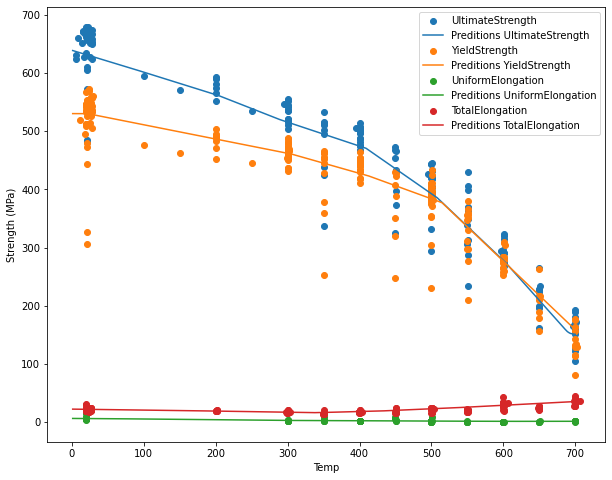

In [47]:
plt.figure(figsize=(10,8))
plt.scatter(
    UltimateStrength_scaler_X.inverse_transform(UltimateStrength_X), 
    UltimateStrength_scaler_y.inverse_transform(UltimateStrength_y), 
    label = "UltimateStrength")
plt.plot(scaler_X.inverse_transform(X_test), UltimateStrength_predictions, label=f"Preditions UltimateStrength")

plt.scatter(
    YieldStrength_scaler_X.inverse_transform(YieldStrength_X), 
    YieldStrength_scaler_y.inverse_transform(YieldStrength_y), 
    label = "YieldStrength")
plt.plot(scaler_X.inverse_transform(X_test), YieldStrength_predictions, label=f"Preditions YieldStrength")

plt.scatter(
    UniformElongation_scaler_X.inverse_transform(UniformElongation_X), 
    UniformElongation_scaler_y.inverse_transform(UniformElongation_y), 
    label = "UniformElongation")
plt.plot(scaler_X.inverse_transform(X_test), UniformElongation_predictions, label = f"Preditions UniformElongation" )

plt.scatter(
    TotalElongation_scaler_X.inverse_transform(TotalElongation_X), 
    TotalElongation_scaler_y.inverse_transform(TotalElongation_y), 
    label = "TotalElongation")
plt.plot(scaler_X.inverse_transform(X_test), TotalElongation_predictions, label = f"Preditions TotalElongation" )

plt.ylabel("Strength (MPa)")
plt.xlabel("Temp")
plt.legend()
plt.show()